# Gaussian Tasks Experiment

## Single-Head FLD

### Empirical Results

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.utils import shuffle
import seaborn as sns
import pandas as pd
sns.set_theme()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [9]:
# support functions
def generate_in_distribution_data(n, mu_o):
    X = np.concatenate((1*np.random.randn(int(n/2))+ (mu_o-1), 1*np.random.randn(int(n/2))+ (mu_o+1)))
    y = np.concatenate((np.zeros((int(n/2), )), np.ones(int(n/2), )))
    X, y = shuffle(X, y)
    return X, y

def generate_out_distribution_data(n, mu_ood):
    X = np.concatenate((1*np.random.randn(int(n/2))+ (mu_ood-1), 1*np.random.randn(int(n/2))+ (mu_ood+1)))
    y = np.concatenate((np.zeros((int(n/2), )), np.ones(int(n/2), )))
    X, y = shuffle(X, y)
    return X, y

def compute_decision_rule(X, y):
    n = len(y)
    mu_hat = (1/n)*np.sum(X - (-1)**y)
    return mu_hat

def compute_empirical_risk(X, y, mu_hat):
    y_pred = (X > mu_hat).astype('int')
    risk = 1 - np.mean(y_pred == y)
    return risk

In [89]:
# params
n = 5
n_test = 1000
mu_o = 0
m_sizes = np.arange(0, 21, 1)
reps = 1000

In [97]:
X_test, y_test = generate_in_distribution_data(n_test, mu_o)

df = pd.DataFrame()
Delta = [0, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 1, 1.5, 2]

i = 0
for m in m_sizes:
    for r, rep in enumerate(range(reps)):
        df.at[i, "m"] = m
        df.at[i, "r"] = r
        X, y = generate_in_distribution_data(n, mu_o)
        
        for delta in Delta:
            X_ood, y_ood = generate_out_distribution_data(m, delta)
            X_comb = np.concatenate((X, X_ood))
            y_comb = np.concatenate((y, y_ood))
            X_comb, y_comb = shuffle(X_comb, y_comb)
            mu_hat = compute_decision_rule(X_comb, y_comb)
            df.at[i, str(delta)] = compute_empirical_risk(X_test, y_test, mu_hat)
        i+=1

In [98]:
df["m"] = df["m"]/n

In [99]:
dfm = df.melt(['m', 'r'], var_name='Delta', value_name='Risk')

(0.0, 4.0)

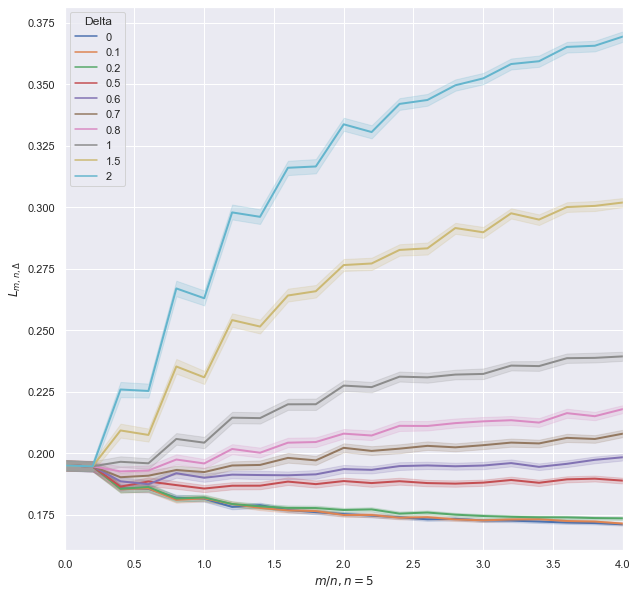

In [100]:
fig1, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Delta", ax=ax, markers=True, ci=95, lw=2)
ax.set_ylabel(r"$L_{m, n, \Delta}$")
ax.set_xlabel(r"$m/n, n=5$")
ax.set_xlim([0, 4])
# ax.set_xticklabels(m_sizes/n)

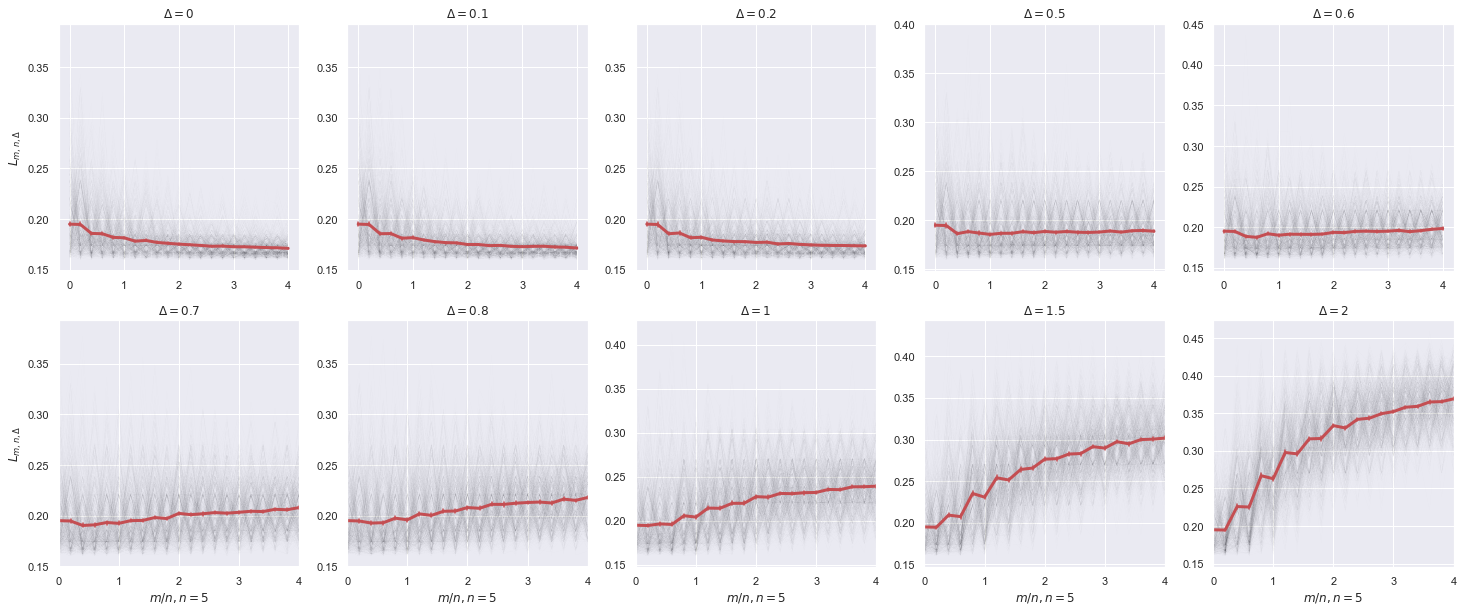

In [101]:
fig2, axs = plt.subplots(2, 5, figsize=(25, 10), facecolor='white')
axs = axs.ravel()
for i, delta in enumerate(Delta):
    ax = sns.lineplot(data=df, x="m", y=str(delta), hue="r", palette=sns.color_palette(['black'], len(df["r"].unique())), ax=axs[i], estimator=None, lw=0.2, alpha=0.01, legend=False)
    ax = sns.lineplot(data=df, x="m", y=str(delta), ax=ax, markers=True, color='r', err_style="bars", lw=3)
    ax.set_title(r"$\Delta = {}$".format(str(delta)))
    ax.set_xlabel("")
    ax.set_ylabel("")
    if i == 0 or i == 5:
        ax.set_ylabel(r"$L_{m, n, \Delta}$")
    if i in np.arange(5, 10, 1):
        ax.set_xlabel(r"$m/n, n=5$")
        ax.set_xlim([0, 4])

In [103]:
# save plots
fig1.savefig("/Users/ashwindesilva/research/ood-tl/reports/figures/gaussian_tasks_sim_plot.svg", bbox_inches="tight")
fig2.savefig("/Users/ashwindesilva/research/ood-tl/reports/figures/gaussian_tasks_rep_plot.svg", bbox_inches="tight")

In [531]:
# save results
df.to_csv("gaussian_task_results.csv")

### Multi-Head FLD

### Theoretical Results

In [52]:
def gen_error(P, Q, A, mu, sigma, pi_t):
    return (1-pi_t) * (1 - norm.cdf((Q + A/(2*P) + mu)/sigma)) +  pi_t * norm.cdf((Q + A/(2*P) - mu)/sigma)

def plot_curves(
    reps = 5000,
    n = 4,
    mu = 1,
    mu_0 = 0,
    sigma = 1,
    m_list = np.arange(0, 20, 0.1),
    pi_in = 0.6,
    pi_out = 0.4,
    delta_list = [0.1, 1.5, 7]
    ):

    df = pd.DataFrame()

    for delta in delta_list:
        k = 0
        for m in m_list.tolist():
            L = 0
            for i in range(reps):
                mu_P = mu - m/(n+m)*(1-2*pi_out)*delta
                s_t = (1 + 4*pi_in*(1-pi_in)*(1-2*pi_in)**2*mu**2)
                s_s = (1 + 4*pi_out*(1-pi_out)*((1-2*pi_out)*mu-delta)**2)
                sigma_P = (n*s_t + m*s_s)/(n+m)**2
                mu_Q = mu_0
                sigma_Q = sigma**2*(1 + 8*mu**2*pi_in*(1-pi_in))/n
                P = np.random.normal(mu_P, np.sqrt(sigma_P))
                Q = np.random.normal(mu_Q, np.sqrt(sigma_Q))
                A = sigma*np.log((1-pi_in)/pi_in)
                L += gen_error(P, Q, A, mu, sigma, pi_in)
            df.at[k, "m"] = m
            df.at[k, delta] = L/reps
            k += 1

    dfm = df.melt(['m'], var_name='Delta', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk",hue="Delta", ax=ax, lw=2, palette='RdYlGn_r')
    ax.set_ylabel("Expected Target Risk")
    ax.set_xlabel(r"$m/n, n=4$")
    ax.set_xlim([0,20])

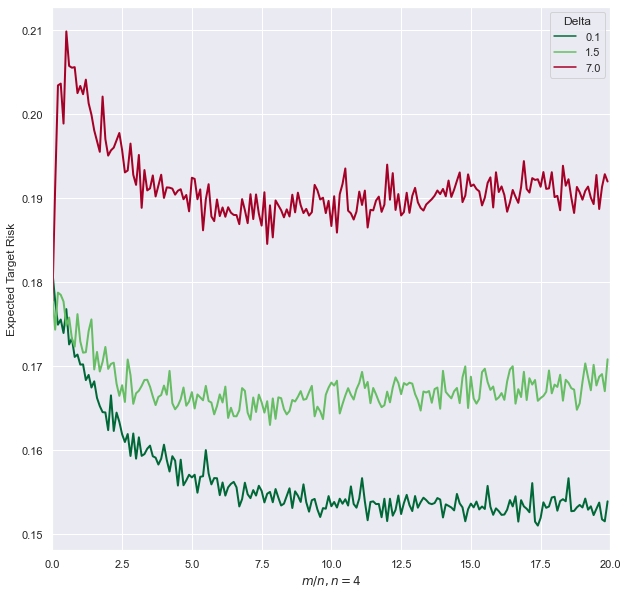

In [53]:
plot_curves(
    reps = 5000,
    n = 4,
    mu = 1,
    mu_0 = 0,
    sigma = 1,
    m_list = np.arange(0, 20, 0.1),
    pi_in = 0.8,
    pi_out = 0.8,
    delta_list = [0.1, 1.5, 7]
    )

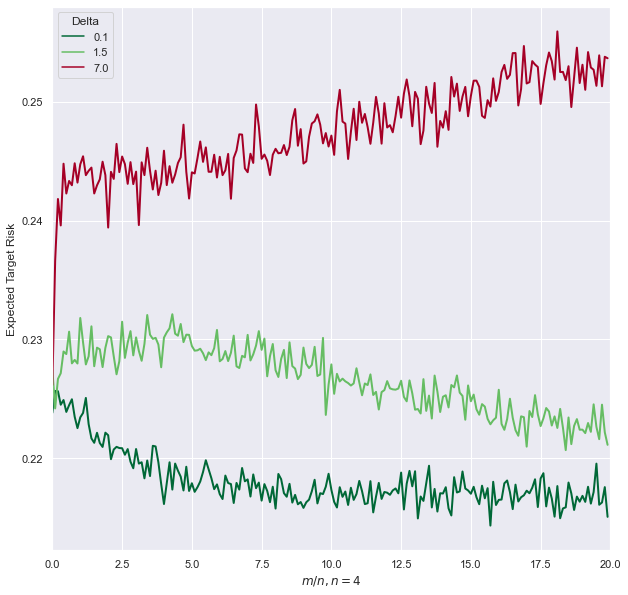

In [54]:
plot_curves(
    reps = 5000,
    n = 4,
    mu = 1,
    mu_0 = 0,
    sigma = 1,
    m_list = np.arange(0, 20, 0.1),
    pi_in = 0.6,
    pi_out = 0.4,
    delta_list = [0.1, 1.5, 7]
    )

### Empirical Results

In [45]:
# support functions
def generate_in_distribution_data(n, mu_0, mu, sigma, pi_in):
    Y = np.random.binomial(size=n, n=1, p=pi_in)
    X = np.random.normal(loc=mu_0 - (-1)**Y*mu*sigma, scale=sigma*np.ones(len(Y)))
    return X, Y

def generate_out_distribution_data(n, mu_0, mu, sigma, pi_out, delta):
    Y = np.random.binomial(size=n, n=1, p=pi_out)
    X = np.random.normal(loc=mu_0 + delta - (-1)**Y*mu*sigma, scale=sigma*np.ones(len(Y)))
    return X, Y

def compute_decision_rule_1(X_in, Y_in, X_out, Y_out, mu_0, pi_in, sigma):
    # MLE solution
    n = len(Y_in)
    m = len(Y_out)
    mu_hat = (1/(n+m))*(np.sum((mu_0 - X_in)*(-1)**Y_in) + np.sum((mu_0 - X_out)*(-1)**Y_out))
    mu_0_hat = (1/n)*np.sum(X_in + (-1)**Y_in*mu*sigma)
    h = mu_0_hat + (sigma/(2*mu_hat))*np.log((1-pi_in)/pi_in)
    return h

def compute_decision_rule_2(X_in, Y_in, X_out, Y_out, mu_0, pi_in, sigma):
    # plugging class means
    m_1 = np.mean(np.concatenate((X_in[Y_in == 1], X_out[Y_out == 1])))
    m_0 = np.mean(np.concatenate((X_in[Y_in == 0], X_out[Y_out == 0])))
    m_1t = np.mean(X_in[Y_in == 1])
    m_0t = np.mean(X_in[Y_in == 0])
    mu_0_hat = (m_1t + m_0t)/2
    h = mu_0_hat + (sigma**2/(m_1 - m_0))*np.log((1-pi_in)/pi_in)
    return h

def compute_empirical_risk(X, Y, h):
    Y_pred = (X > h).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

In [58]:
def run_simulation(
    n = 4,
    n_test = 500,
    mu_0 = 0,
    mu = 1,
    sigma = 1,
    pi_in = 0.8,
    pi_out = 0.8,
    Delta = [0.1, 1.5, 7],
    m_sizes = np.arange(0, 21, 1),
    reps = 5000,
    dec_rule=1
):
    X_test, y_test = generate_in_distribution_data(n_test, mu_0, mu, sigma, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu_0, mu, sigma, pi_in)
            
            for delta in Delta:
                X_out, Y_out = generate_out_distribution_data(m, mu_0, mu, sigma, pi_out, delta)
                if dec_rule == 1:
                    h = compute_decision_rule_1(X_in, Y_in, X_out, Y_out, mu_0, pi_in, sigma)
                else:
                    h = compute_decision_rule_2(X_in, Y_in, X_out, Y_out, mu_0, pi_in, sigma)
                df.at[i, str(delta)] = compute_empirical_risk(X_test, y_test, h)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Delta', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Delta", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel(r"$L_{m, n, \Delta}$")
    ax.set_xlabel(r"$m/n, n=4$")
    ax.set_xlim([0, 20])

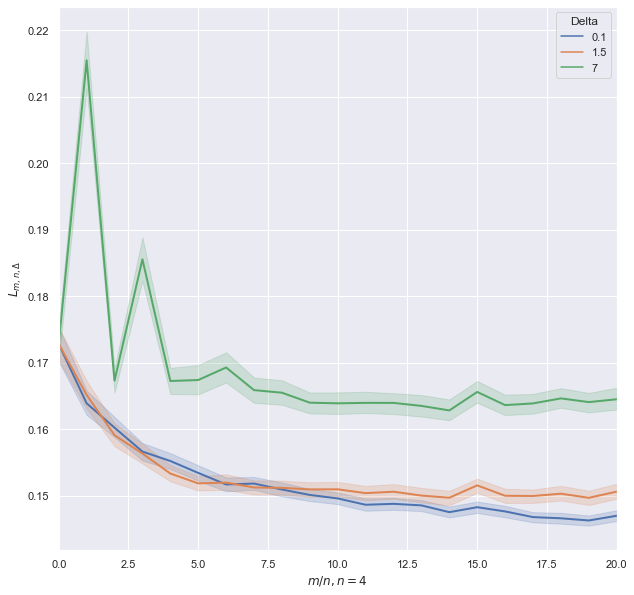

In [59]:
# pi_in = pi_out = 0.8 (MLE Method)
run_simulation(
    n = 4,
    n_test = 500,
    mu_0 = 0,
    mu = 1,
    sigma = 1,
    pi_in = 0.8,
    pi_out = 0.8,
    Delta = [0.1, 1.5, 7],
    m_sizes = np.arange(0, 21, 1),
    reps = 5000,
    dec_rule=1
)

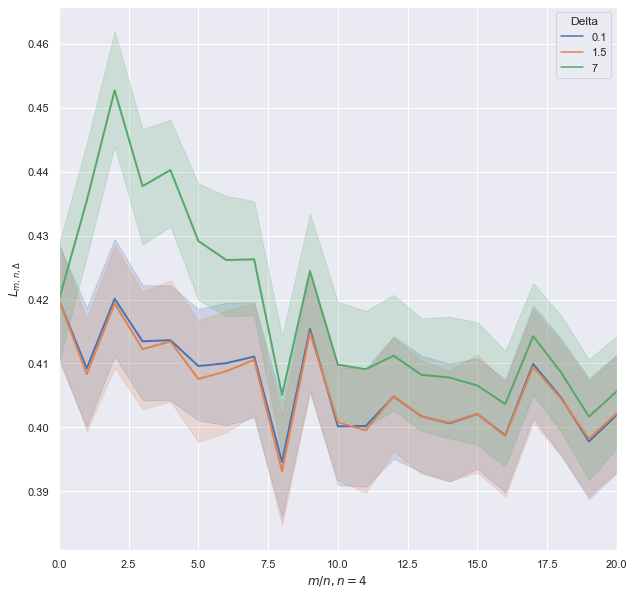

In [64]:
# pi_in = pi_out = 0.8 (meta class Method)
run_simulation(
    n = 4,
    n_test = 500,
    mu_0 = 0,
    mu = 1,
    sigma = 1,
    pi_in = 0.8,
    pi_out = 0.8,
    Delta = [0.1, 1.5, 7],
    m_sizes = np.arange(0, 21, 1),
    reps = 5000,
    dec_rule=2
)

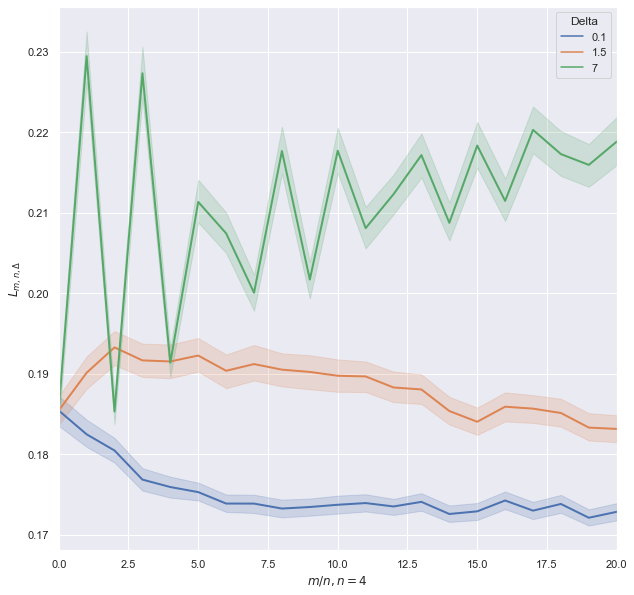

In [61]:
# pi_in = 0.6, pi_out = 0.4 (MLE Method)
run_simulation(
    n = 4,
    n_test = 500,
    mu_0 = 0,
    mu = 1,
    sigma = 1,
    pi_in = 0.6,
    pi_out = 0.4,
    Delta = [0.1, 1.5, 7],
    m_sizes = np.arange(0, 21, 1),
    reps = 5000,
    dec_rule=1
)

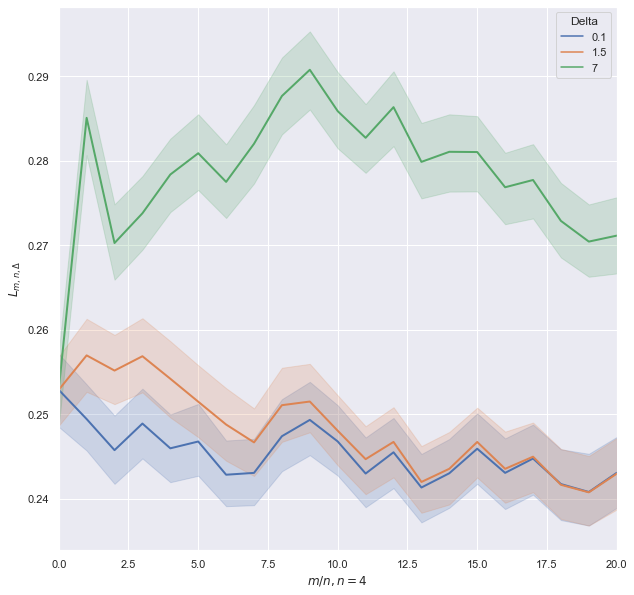

In [65]:
# pi_in = 0.6, pi_out = 0.4 (meta class Method)
run_simulation(
    n = 4,
    n_test = 500,
    mu_0 = 0,
    mu = 1,
    sigma = 1,
    pi_in = 0.6,
    pi_out = 0.4,
    Delta = [0.1, 1.5, 7],
    m_sizes = np.arange(0, 21, 1),
    reps = 5000,
    dec_rule=2
)